In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import csv

<h1>Text preprocessing</h1>
Code adapted from: https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639

In [11]:
import re
import string

def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = text.replace("i'm", "i am")
    # text = re.sub(r"i'm", "i am", text)
    text = text.replace("he's", "he is")
    text = text.replace("she's", "she is")
    text = text.replace("it's", "it is")
    text = text.replace("what's", "that is")
    text = text.replace("that's", "that is")
    text = text.replace("where's", "where is")
    text = text.replace("how's", "how is")
    text = text.replace("\'ll", " will")
    text = text.replace("\'re", " are")
    text = text.replace("\'ve", " have")
    text = text.replace("\'d", " would")
    text = text.replace("won't", "will not")
    text = text.replace("can't", "cannot")
    text = text.replace("n't", " not")
    text = text.replace("n'", "ng")
    text = text.replace("'bout", "about")
    text = text.replace("'til", "until")
    text = re.sub(' +', ' ', text)
    # if text != ":)" or text != ":(":
    #     text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    return text

start_char = "<START>"
end_char = "<END>"

posts = []
comments_output = []
comments_input = []

with open('../encouragement_comments.csv', 'r', newline='') as csv_file:
    textReader = csv.reader(csv_file)
    for row in textReader:
        cleaned_text = clean_text(row[1])
        posts.append(" ".join(re.findall(r"[\w']+|[.,!?;]", cleaned_text)))

        cleaned_text = clean_text(row[0])
        cleaned_text = re.findall(r"[\w']+|[.,!?;]", cleaned_text)
        cleaned_text = [ x.strip() for x in cleaned_text ]
        cleaned_text = [start_char] + cleaned_text + [end_char]
        comments_output.append(" ".join(cleaned_text[1:]))
        comments_input.append(" ".join(cleaned_text[:-1]))
print("Num samples posts: ", len(posts))
print("Num samples comments output", len(comments_output))
print("Num samples comments input", len(comments_input))
print(posts[500])
print(comments_output[500])
print(comments_input[500])

Num samples posts:  965
Num samples comments output 965
Num samples comments input 965
when we started dating 5 years ago , i told her how much i wanted children . she said she could want kids with me . apparently , she is changed her mind and does not want kids at all now , and i just do not think i could be fulfilled without children . i do not want to lose her and our dog . i just feel so bad right now .
im really sorry to hear that . may i ask why she doesnt want children ? or perhaps ask her why if you havent already . is she open to adopting maybe ? <END>
<START> im really sorry to hear that . may i ask why she doesnt want children ? or perhaps ask her why if you havent already . is she open to adopting maybe ?


In [12]:
# Generate all the unique words in the data set
all_words = set()
all_text = posts + comments_output + comments_input
for sentence in all_text:
    for word in sentence.split():
        all_words.add(word)
print("Total number of unique words: ", len(all_words))

for i, word in enumerate(all_words):
    if i < 5:
        print(word)
    else: break

Total number of unique words:  8453
attacked
fried
reverses
bursts
aware


In [13]:
from keras.preprocessing.text import Tokenizer
from scipy import stats

vocab_size = len(all_words)
tokenizer = Tokenizer(num_words = vocab_size+1, filters='', lower=False)
tokenizer.fit_on_texts(all_text)
word_to_index = tokenizer.word_index
index_to_word = {v:k for k,v in word_to_index.items()}
print("Total unique words: ", len(word_to_index))

posts_sequence = tokenizer.texts_to_sequences(posts)
MAX_POST_LEN = max(len(seq) for seq in posts_sequence)
average_post_length = np.average([len(seq) for seq in posts_sequence])
median_post_length = np.median([len(seq) for seq in posts_sequence])
print("Max post length: ", MAX_POST_LEN)
print("Average post length: ", average_post_length)
print("median_post_length: ", median_post_length)

comments_output_sequence = tokenizer.texts_to_sequences(comments_output)
comments_input_sequence = tokenizer.texts_to_sequences(comments_input)
MAX_COMMENT_LEN = max(len(seq) for seq in comments_output_sequence)
average_comment_length = np.average([len(seq) for seq in comments_output_sequence])
median_comment_length = np.median([len(seq) for seq in comments_output_sequence])
print("Max comment length: ", MAX_COMMENT_LEN)
print("Average comment length: ", average_comment_length)
print(np.average([len(seq) for seq in comments_input_sequence]))
print("median_comment_length: ", median_comment_length)

AVG_POST_LEN = int(round(average_post_length))
print(AVG_POST_LEN)
AVG_COMMENT_LEN = int(round(average_comment_length))
print(AVG_COMMENT_LEN)

# index_to_word = dict()
# for k, v in word_to_index.items():
#     index_to_word[v] = k

Total unique words:  8453
Max post length:  3501
Average post length:  202.76269430051815
median_post_length:  134.0
Max comment length:  923
Average comment length:  95.30259067357512
95.30259067357512
median_comment_length:  66.0
203
95


In [14]:
# Truncate the output to the average length of a comment (203)
truncated = []
for comment in comments_input_sequence:
    if len(comment) > 95:
        truncated.append(comment[:95])
    else:
        truncated.append(comment)
comments_input_sequence = truncated.copy()
print(comments_input_sequence[:5])
truncated = []

for comment in comments_output_sequence:
    if len(comment) > 95:
        truncated.append(comment[:94] + [word_to_index['<END>']])
    else:
        truncated.append(comment)
comments_output_sequence = truncated.copy()
print(comments_output_sequence[:5])

print(np.average([len(seq) for seq in comments_output_sequence]))
print(np.average([len(seq) for seq in comments_input_sequence]))
print(max([len(seq) for seq in comments_output_sequence]))
print(max([len(seq) for seq in comments_input_sequence]))



[[57, 2077, 6, 200, 17, 7, 3917, 36, 3196, 881, 36, 1252, 27, 125, 3144, 109, 51, 1, 6, 33, 20, 9, 30, 99, 7, 341, 12, 35, 1209, 7, 299, 738, 169, 242, 6, 4225, 4, 20, 394, 155, 1, 6, 2975, 3, 6, 576, 3, 17, 7, 739, 11, 1429, 3, 5821, 418, 3, 2730, 3, 5822, 3, 962, 3, 5, 273, 20, 7, 2819, 125, 64, 4, 4028, 1, 42, 16, 2055, 787, 112, 238, 2, 92, 55, 74, 15, 16, 72, 881, 32, 10, 9, 335, 4, 196, 637, 27, 7], [57, 55, 2, 32, 15, 226, 3, 2, 383, 4, 535, 15, 1028, 953, 1281, 639, 27, 5834, 1, 617, 1263, 5835, 3, 128, 9, 7, 118, 34, 6, 24, 15, 76, 11, 7, 96, 1], [57], [57, 22, 224, 3, 16, 219, 6, 552, 12, 650, 7, 115, 1415, 1, 5836, 5837, 2534, 5838, 518, 5839, 1, 617, 5840, 5841, 2195, 22, 224, 1, 6, 24, 14, 250, 1, 52, 24, 40, 650, 8, 188, 1415, 91, 154, 91, 3, 5, 9, 174, 37, 604, 27, 45, 1, 6, 1131, 4, 606, 10, 40, 165, 487, 435, 24, 26, 435, 1, 67, 20, 14, 391, 155, 3, 5, 67, 24, 14, 1671, 623, 1, 6, 33, 37, 41, 11, 582, 833, 165, 435, 1, 6, 33, 17, 1707, 5, 1183, 833], [57, 149, 31, 22, 

In [15]:
#PADDING

padded_post_sequences = pad_sequences(posts_sequence, maxlen=AVG_POST_LEN, truncating='post')
padded_comment_input_sequences = pad_sequences(comments_input_sequence, maxlen=AVG_COMMENT_LEN, padding='post')
padded_comment_output_sequences = pad_sequences(comments_output_sequence, maxlen=AVG_COMMENT_LEN, padding='post')
print("padded_post_sequences.shape", padded_post_sequences.shape)
print("padded_post_sequences[500]", padded_post_sequences[500])
print(word_to_index['we'])
print(padded_comment_input_sequences.shape)
print(padded_comment_input_sequences[500])
print(word_to_index['<START>'])

# encoder_sequences = tokenizer.texts_to_sequences(posts)
# encoder_sequences_padded = pad_sequences(encoder_sequences, maxlen=max_source_length, dtype='int32', padding='post', truncating='post')
# decoder_sequences = tokenizer.texts_to_sequences(comments)
# decoder_sequences_padded = pad_sequences(decoder_sequences, maxlen=max_target_length, dtype='int32', padding='post', truncating='post')

padded_post_sequences.shape (965, 203)
padded_post_sequences[500] [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   55   52  260  874  377  133  259    3    2  229   77
   73  101    2  206  918    1   71  220   71   97   62  477   27   19
    1 4181    3   71   12  736   77  300    5  174   14   62  477   39
   40   51    3    5    2   26   20   14   83    2   97   22 2074  306
  918    1 

In [16]:
# Layer will consider the top 20000 words and will pad or truncate words to be 200 words long 
# vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
# text_ds = tf.data.Dataset.from_tensor_slices(comments).batch(128)
# vectorizer.adapt(text_ds)
# print(vectorizer.get_vocabulary()[:5])

#dict mapping words to their indices
# voc = vectorizer.get_vocabulary()
# word_index = dict(zip(voc, range(len(voc))))

embeddings_dictionary = {}
with open('./glove6B/glove.6B.100d.txt', 'r') as glove:
    for line in glove:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

print("Found %s word vectors." % len(embeddings_dictionary))

Found 400000 word vectors.


In [17]:
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_to_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

print(embeddings_dictionary["we"])
print(embedding_matrix.shape)

. 1
i 2
, 3
to 4
and 5
you 6
a 7
the 8
it 9
that 10
of 11
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.33978999  0.20941     0.46348    ... -0.23394001  0.47297999
  -0.028803  ]
 [-0.046539    0.61966002  0.56647003 ... -0.37616    -0.032502
   0.80620003]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Converted 10 words (0 misses)
[-0.17791   0.62675   0.4787   -0.55295  -0.84935  -0.070802 -0.34724
  0.4628    0.12611  -0.24875   0.46881   0.083636  0.56065  -0.21931
  0.015561 -0.55806  -0.20738   0.9123   -1.2034    0.30115   0.46676
  0.483    -0.10204  -0.56799  -0.027126  0.40567  -0.14058  -0.55485
  0.094588 -0.62213  -0.30343   0.60639   0.049799  0.22204   0.48549
  0.17629  -0.090535  0.53705   0.2755   -0.78827  -0.70953  -0.16678
  0.11206  -0.48491  -0.66644   0.

<h1>Embedding Layer</h1>
The size of the embedding layer is the size of the vector that represents each word. We usually match the size of the embedding layer output with the number of hidden layers in the LSTM cell. 

The size of the hidden layer is equal to the number nodes representing the signmoid, tanh and hidden state layer in the LSTM cell. 

In [13]:
from keras.initializers import Constant
# embedding_layer = Embedding(vocab_size+1, embedding_dim, embeddings_initializer=Constant(embedding_matrix),  trainable=False)
print(vocab_size+1)
embedding_layer = Embedding(vocab_size+1, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=AVG_POST_LEN, trainable=False)


8454


CREATING THE MODEL

In [14]:
decoder_targets_one_hot = np.zeros((
    len(posts),
    AVG_COMMENT_LEN,
    vocab_size+1
    ), 
    dtype='float32' 
)
print(decoder_targets_one_hot.shape)

# # One-hot encoding of the output
# num_samples = len(encoder_sequences)
# decoder_output_data = np.zeros((num_samples, max_target_length, vocab_size), dtype='float32')
for i, seqs in enumerate(padded_comment_output_sequences):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_targets_one_hot[i, j, seq] = 1

(965, 95, 8454)


In [15]:
# Defining the encoder

latent_dim = 512 #LSTM_NODES = latent_dim. Either set to 256 or 50???

encoder_inputs = Input(shape=(AVG_POST_LEN,)) # shape=(None,), dtype="int64"
enc_emb = embedding_layer(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [16]:
# Defining the decoder

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(AVG_COMMENT_LEN,)) 
dec_emb_layer = Embedding(vocab_size+1, latent_dim)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

In [17]:
# Output from the decoder LSTM

decoder_dense = Dense(vocab_size+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [19]:

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

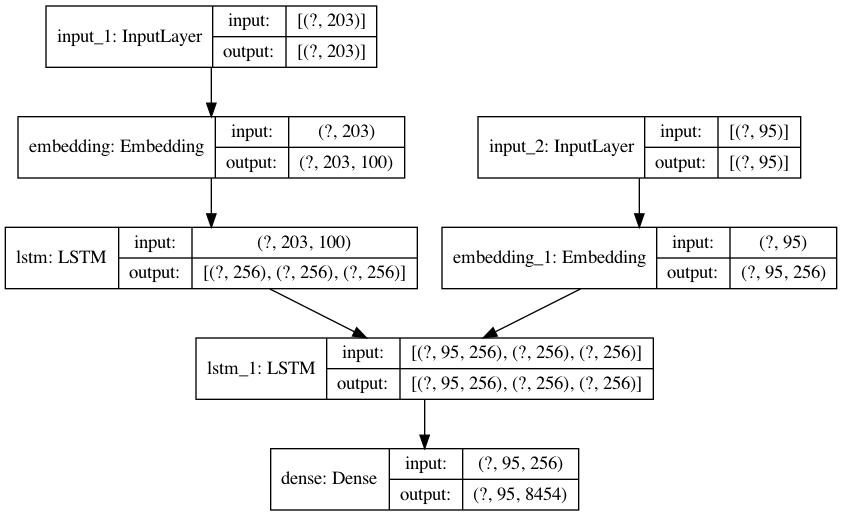

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='../LSTM/model.png', show_shapes=True, show_layer_names=True)

In [16]:
print(encoder_inputs.shape, decoder_inputs.shape)
print(decoder_inputs.shape)
print(padded_post_sequences.shape)
print(padded_comment_input_sequences.shape)

(None, 203) (None, 95)
(None, 95)
(965, 203)
(965, 95)


In [17]:

r = model.fit(
    x=[padded_post_sequences, padded_comment_input_sequences],
    y=decoder_targets_one_hot,
    batch_size=64,
    epochs=200,
    validation_split=0.1,
)

model.save("s2s")
#model.save_weights('saved_weights.hdf5', overwrite=True)

Epoch 1/100
14/14 [==============================] - 23s 2s/step - loss: 5.8947 - accuracy: 0.3342 - val_loss: 4.0088 - val_accuracy: 0.4460
Epoch 2/100
14/14 [==============================] - 22s 2s/step - loss: 4.4157 - accuracy: 0.3587 - val_loss: 3.7763 - val_accuracy: 0.4460
Epoch 3/100
14/14 [==============================] - 22s 2s/step - loss: 4.1711 - accuracy: 0.3607 - val_loss: 3.4669 - val_accuracy: 0.4460
Epoch 4/100
14/14 [==============================] - 22s 2s/step - loss: 3.9091 - accuracy: 0.3752 - val_loss: 3.3840 - val_accuracy: 0.4691
Epoch 5/100
14/14 [==============================] - 22s 2s/step - loss: 3.8419 - accuracy: 0.3860 - val_loss: 3.3596 - val_accuracy: 0.4685
Epoch 6/100
14/14 [==============================] - 22s 2s/step - loss: 3.8015 - accuracy: 0.3860 - val_loss: 3.3229 - val_accuracy: 0.4688
Epoch 7/100
14/14 [==============================] - 22s 2s/step - loss: 3.7488 - accuracy: 0.3869 - val_loss: 3.3027 - val_accuracy: 0.4689
Epoch 8/100
1

In [18]:
model = keras.models.load_model("s2s")
model.summary()
# for idx, layer in enumerate(model.layers):
#     print(idx, layer.name)
# return
encoder_inputs = model.input[0]  # input_1
# for i in range(6):
#     print(i)
#     print(model.layers[i].output)
encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

# for i in range(4):
#     print(model.input[i])

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs_single_x, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

def give_encouragement(input_seq):
    # encoder_model.load_weights("../LSTM/encoder_model_weights.hdf5")
    # decoder_model.load_weights("../LSTM/decoder_model_weights.hdf5")
    
    # # KERAS
    # states_value = encoder_model.predict(input_seq)

    # # Generate empty target sequence of length 1.
    # target_seq = np.zeros((1, 1, vocab_size))
    # # Populate the first character of target sequence with the start character.
    # target_seq[0, 0, word_to_index['<START>']] = 1.0

    # # Sampling loop for a batch of sequences
    # # (to simplify, here we assume a batch of size 1).
    # stop_condition = False
    # decoded_sentence = ""
    # while not stop_condition:
    #     output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    #     # Sample a token
    #     sampled_token_index = np.argmax(output_tokens[0, -1, :])
    #     sampled_char = index_to_word[sampled_token_index]
    #     decoded_sentence += sampled_char

    #     # Exit condition: either hit max length
    #     # or find stop character.
    #     if sampled_char == "<END>" or len(decoded_sentence) > AVG_COMMENT_LEN:
    #         stop_condition = True

    #     # Update the target sequence (of length 1).
    #     target_seq = np.zeros((1, 1, word_to_index['<START>']))
    #     target_seq[0, 0, sampled_token_index] = 1.0

    #     # Update states
    #     states_value = [h, c]
    # return decoded_sentence

    # # The french one
    # print(input_seq.shape)
    # states_value = encoder_model.predict(input_seq)
    # target_seq = np.zeros((1, 1))
    # target_seq[0, 0] = word_to_index['<START>']
    # eos = word_to_index['<END>']
    # output_sentence = []
    # for _ in range(AVG_COMMENT_LEN):
    #     # print(states_value)
    #     # print(target_seq.shape)
    #     # inputs = [target_seq] + states_value
    #     # print(inputs)
    #     # print(states_value)
    #     # for i in range(len(states_value)):
    #     #     states_value[i] = np.asarray(states_value[i])
    #     # print(states_value)
    #     # temp = [target_seq]
    #     # print(temp)
    #     # temp.append(states_value)
    #     # for i in [target_seq] + states_value:
    #         # print(i.shape)
    #     output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    #     idx = np.argmax(output_tokens[0, 0, :])

    #     if eos == idx:
    #         break

    #     word = ''

    #     if idx > 0:
    #         word = index_to_word[idx]
    #         output_sentence.append(word)

    #     target_seq[0, 0] = idx
    #     states_value = [h, c]

    # return ' '.join(output_sentence)

    # The weird one
    # #Getting the output states to pass into the decoder
    # states_value = encoder_model.predict(input_seq)
    # #Generating empty target sequence of length 1
    # target_seq = np.zeros((1, 1, vocab_size+1))
    # #Setting the first token of target sequence with the start token
    # target_seq[0, 0, word_to_index['<START>']] = 1.
    
    # #A variable to store our response word by word
    # decoded_sentence = ''
    
    # stop_condition = False
    # while not stop_condition:
    #   #Predicting output tokens with probabilities and states
    #   output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
    #   #Choosing the one with highest probability
    #   sampled_token_index = np.argmax(output_tokens[0, -1, :])
    #   sampled_token = index_to_word[sampled_token_index]
    #   decoded_sentence += " " + sampled_token#Stop if hit max length or found the stop token
    #   if (sampled_token == '<END>' or len(decoded_sentence) > AVG_COMMENT_LEN):
    #       stop_condition = True
    #   #Update the target sequence
    #   target_seq = np.zeros((1, 1, vocab_size+1))
    #   target_seq[0, 0, sampled_token_index] = 1.
    #   #Update states
    #   states_value = [hidden_state, cell_state]
    # return decoded_sentence

    #Marathi one
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = word_to_index['<START>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_word[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<END>' or len(decoded_sentence) > AVG_COMMENT_LEN):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 203)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 95)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 203, 100)     845400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 95, 256)      2164224     input_2[0][0]                    
_______________________________________________________________________________________

SyntaxError: 'return' outside function (<ipython-input-18-c8df3dffca20>, line 5)

In [42]:
# for _ in range(5):
# for seq_index in range(2):
#     # Take one sequence (part of the training set)
#     # for trying out decoding.
#     input_seq = encoder_input_data[seq_index : seq_index + 1]
for _ in range(5):
    i = np.random.choice(len(posts))
    input_seq = padded_post_sequences[i:i+1]
    generated_comment = give_encouragement(input_seq)
    print('-')
    print('Post: ', posts[i])
    print('Generated Comment: ', generated_comment)
    print("Actual Comment: ", comments_input[i])

-
Post:  right now im sitting in my dark and empty house and i dont know if i can do this thing called life . ive been battling this demon for years now . no one knows whats really going on with me . ive tried to talk to people about it but they all have the same carbon copied answers youre gonna be okay . itll get better soon . im sorry youre going through this . i dont think i will though . i know i need to talk this out with a professional , but i cant afford that or the insurance to cover it . its cruel how the world keeps on going after your own world lies in ashes at your feet . tbh , i feel empty inside . i have for quite a while now . thats not really the truth though . i do feel something . fear . im afraid of losing those i care about . im afraid that im not good enough . even now , im afraid that youre thinking im being melodramatic when all im really doing is trying to describe whats going on in my head . i know im self destructive and i dont care . that makes me afraid of 

In [18]:
# print(encoder_inputs.shape, encoder_states[0].shape, encoder_states[1].shape)
# print(decoder_state_input_h.shape)
# print(decoder_state_input_c.shape)
# print(decoder_inputs_single.shape)
# print(decoder_outputs.shape)
# for i in decoder_states_inputs:
#     print(i.shape)

(None, 203) (None, 256) (None, 256)


NameError: name 'decoder_state_input_h' is not defined

In [19]:
from keras.utils import plot_model
# # Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file='../LSTM/model_plot_enc.png', show_shapes=True, show_layer_names=True)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = dec_emb_layer(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

# dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# # To predict the next word in the sequence, set the initial states to the states from the previous time step
# decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
# decoder_states2 = [state_h2, state_c2]
# decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

# # Encode the input sequence to get the "thought vectors"
# encoder_model = Model(encoder_inputs, encoder_states)

# # Decoder setup
# # Below tensors will hold the states of the previous time step
# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# # To predict the next word in the sequence, set the initial states to the states from the previous time step
# decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
# decoder_states2 = [state_h2, state_c2]
# decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# # Final decoder model
# decoder_model = Model(
#     [decoder_inputs] + decoder_states_inputs,
#     [decoder_outputs2] + decoder_states2)


plot_model(decoder_model, to_file='../LSTM/model_plot_dec.png', show_shapes=True, show_layer_names=True)
encoder_model.save_weights('encoder_model_weights.hdf5', overwrite=True)
decoder_model.save_weights('decoder_model_weights.hdf5', overwrite=True)

NameError: name 'encoder_inputs' is not defined

Keras LSTM Architecture

The input shape of the text data is ordered as follows: batch size, number of time steps, hidden size (size of the hidden layer)
For each batch sample and each word in the number of time steps, there is a l500 length embedding word vector to 